# AirBnB : Part 2, Model Selection ALL CITIES

In [21]:
%matplotlib inline 

import matplotlib.pyplot as plt

from time import time
import numpy as np
import pandas as pd

import seaborn as sns

import statsmodels.api as sm

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression,RandomizedLogisticRegression

from sklearn.svm import SVC
from sklearn.metrics import r2_score, mean_squared_error,confusion_matrix,classification_report
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.grid_search import GridSearchCV

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler,LabelEncoder

from xgboost import XGBClassifier
from utils import rstr,distance

import pickle

airBColor= '#ff5a5f'
airBColor2= '#008489'

In [22]:
df = pd.read_csv('../../data/all_cities/listing_cleansed_fillna.csv')
print df.host_id.isnull().sum()
df.drop('listings_per_host',axis=1,inplace=True)

df.loc[df['maximum_nights'] > 365, 'maximum_nights'] = 365

0


In [23]:
#df = pd.read_csv('../../data/all_cities/dataset_for_modeling.csv')
features_RLR =  pickle.load(open('best_features/features_RLR.p', 'rb'))
features_Kbest_chi2=  pickle.load(open('best_features/features_Kbest_chi2.p', 'rb'))
features_Kbest_fclass=  pickle.load(open('best_features/features_Kbest_fclass.p', 'rb'))
features_XBOOST =  pickle.load(open('best_features/XGB_features.p', 'rb'))

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
features_ALL = df.select_dtypes(include=numerics).columns.tolist()

In [24]:
df.shape

(56879, 400)

In [25]:
df=df[['multihost']+ features_RLR]

In [26]:
df.shape

(56879, 67)

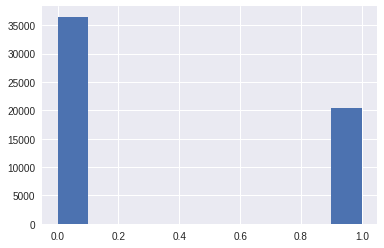

In [27]:
df.multihost.hist()

### Filter on listings with high reviews number

### Fill the missing data

In [28]:
df_missing_data = pd.DataFrame(df.isnull().sum()/len(df)*100).sort_values(by=0,ascending=False)
df_missing_data.columns = ['missing_percent']
df_missing_data = df_missing_data[df_missing_data.missing_percent>0]
df_missing_data

,missing_percent


## Linear Model and R-squared

In [29]:
TARGET_CLASSIFICATION ='multihost'
y = df[TARGET_CLASSIFICATION]

X = df.drop(TARGET_CLASSIFICATION,axis=1)

### Train test split

In [30]:
def balanced_subsample(y, size=None):

    subsample = []

    if size is None:
        n_smp = y.value_counts().min()
    else:
        n_smp = int(size / len(y.value_counts().index))

    for label in y.value_counts().index:
        samples = y[y == label].index.values
        index_range = range(samples.shape[0])
        indexes = np.random.choice(index_range, size=n_smp, replace=False)
        subsample += samples[indexes].tolist()

    return subsample

In [31]:
rebalanced_index = balanced_subsample(y)

In [32]:
X,y = X.loc[rebalanced_index],y.loc[rebalanced_index]

In [33]:
y.value_counts()

1    20385
0    20385
Name: multihost, dtype: int64

In [34]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2)
features = pd.Series(X.columns)
#scaler = MinMaxScaler()

#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)
print y_test.value_counts()

0    4080
1    4074
Name: multihost, dtype: int64


In [35]:
def cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=5):
    gs = GridSearchCV(clf, param_grid=params, cv=n_folds, n_jobs=-1,scoring="recall")
    gs.fit(Xtrain, ytrain)
    
    return gs.best_estimator_

### Logistic Regression

In [36]:
lm = LogisticRegression(C=1e5)
lm.fit(X_train,y_train)
prediction = lm.predict(X_test)
print confusion_matrix(y_test,prediction)
print classification_report(y_test,prediction)

[[3045 1035]
 [ 915 3159]]
             precision    recall  f1-score   support

          0       0.77      0.75      0.76      4080
          1       0.75      0.78      0.76      4074

avg / total       0.76      0.76      0.76      8154



### Random Forest

In [37]:
clf = RandomForestClassifier()
params={}
best_clf = cv_optimize(clf,params,X_train,y_train)

print(best_clf)

prediction = best_clf.predict(X_test)
print confusion_matrix(y_test,prediction)
print classification_report(y_test,prediction)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
[[3236  844]
 [1159 2915]]
             precision    recall  f1-score   support

          0       0.74      0.79      0.76      4080
          1       0.78      0.72      0.74      4074

avg / total       0.76      0.75      0.75      8154



### XGB

In [38]:
params = {
    'max_depth':12,
    'min_child_weight':2,
    'learning_rate' :0.1,
    'gamma':0.0,
    'n_estimators':200
}

print params

clf = XGBClassifier(**params)

#best_clf = cv_optimize(clf,params,X_train,y_train)
best_clf = clf.fit(X_train,y_train)
print(best_clf)

{'n_estimators': 200, 'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 12, 'min_child_weight': 2}
XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0.0, learning_rate=0.1, max_delta_step=0, max_depth=12,
       min_child_weight=2, missing=None, n_estimators=200, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)


In [72]:
prediction = best_clf.predict_proba(X_test)
print prediction[:,1]
print confusion_matrix(y_test,prediction[:,1]>.5)

print classification_report(y_test,prediction[:,1]>.5)

[ 0.74303842  0.83916104  0.91635603 ...,  0.96812439  0.19221179
  0.99327916]
[[3284  796]
 [ 735 3339]]
             precision    recall  f1-score   support

          0       0.82      0.80      0.81      4080
          1       0.81      0.82      0.81      4074

avg / total       0.81      0.81      0.81      8154



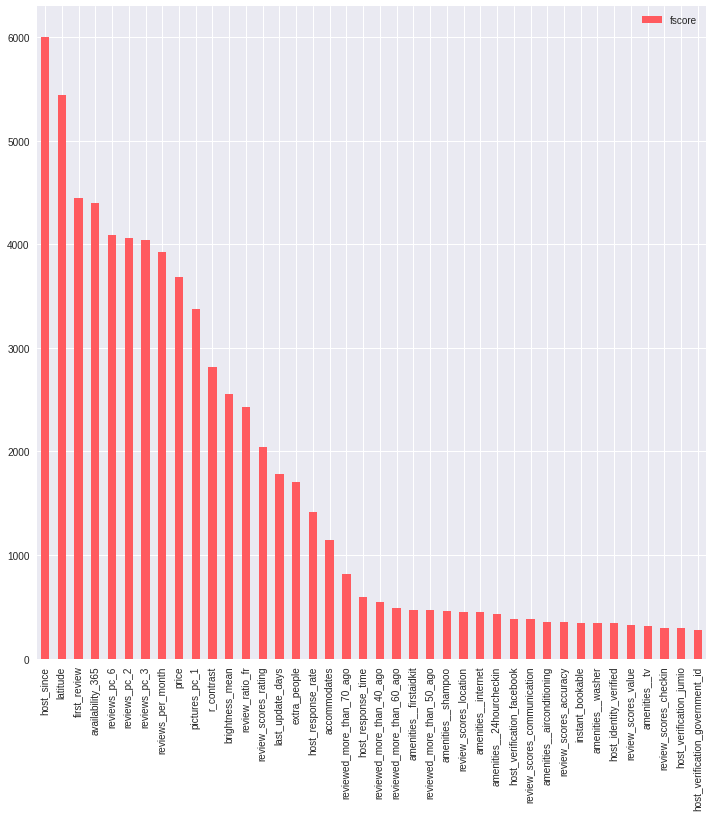

In [40]:
features_weights = pd.DataFrame.from_dict(best_clf.booster().get_fscore(),orient="index")
features_weights.columns = ['fscore']

features_weights.sort_values(by='fscore',ascending=False).head(40).plot(kind='bar',title='',color=airBColor,figsize=(12,12))

In [57]:
# calculate the fpr and tpr for all thresholds of the classification
probs = best_clf.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

/home/ramon/anaconda2/lib/python2.7/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/home/ramon/anaconda2/lib/python2.7/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp


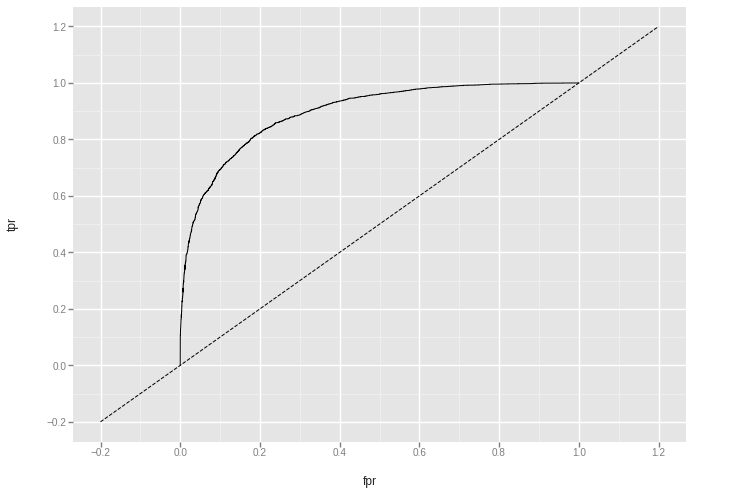

<ggplot: (8751474167221)>

In [42]:
from ggplot import *
df = pd.DataFrame(dict(fpr = fpr, tpr = tpr))
ggplot(df, aes(x = 'fpr', y = 'tpr')) + geom_line() + geom_abline(linetype = 'dashed')